In [3]:
import os
import sys
from datetime import datetime
from pathlib import Path

import numpy as np
import soundfile as sf
from cached_path import cached_path
from hydra.utils import get_class
from omegaconf import OmegaConf
from importlib.resources import files

sys.path.append("/mnt/workspace/zhangjunan/F5-TTS/src/")

from f5_tts.infer.utils_infer import (
    device,
    infer_process,
    load_model,
    load_vocoder,
)

model_name = "F5TTS_v1_Base"
vocoder_name = "vocos"

vocoder = load_vocoder(vocoder_name=vocoder_name, device=device)
model_config_path = str(files("f5_tts").joinpath(f"configs/{model_name}.yaml"))
model_cfg = OmegaConf.load(model_config_path)

repo_name, ckpt_step, ckpt_type = "F5-TTS", 1250000, "safetensors"
checkpoint_path = str(cached_path(f"hf://SWivid/{repo_name}/{model_name}/model_{ckpt_step}.{ckpt_type}"))

model_cls = get_class(f"f5_tts.model.{model_cfg.model.backbone}")
model_arc = model_cfg.model.arch

ema_model = load_model(
    model_cls, 
    model_arc, 
    checkpoint_path, 
    mel_spec_type=vocoder_name, 
    device=device
)

Download Vocos from huggingface charactr/vocos-mel-24khz

vocab :  /mnt/workspace/zhangjunan/F5-TTS/src/f5_tts/infer/examples/vocab.txt
token :  custom
model :  /mnt/workspace/zhangjunan/.cache/huggingface/hub/models--SWivid--F5-TTS/snapshots/84e5a410d9cead4de2f847e7c9369a6440bdfaca/F5TTS_v1_Base/model_1250000.safetensors 



选择的测试音频文件: /mnt/workspace/zhangjunan/F5-TTS/src/f5_tts/infer/tests/dns2020_no_reverb_noisy/clean_fileid_9.wav
Noisy Mel shape: torch.Size([1, 938, 100])


PnP Step 32/32: 100%|██████████| 32/32 [00:00<00:00, 47.54it/s]


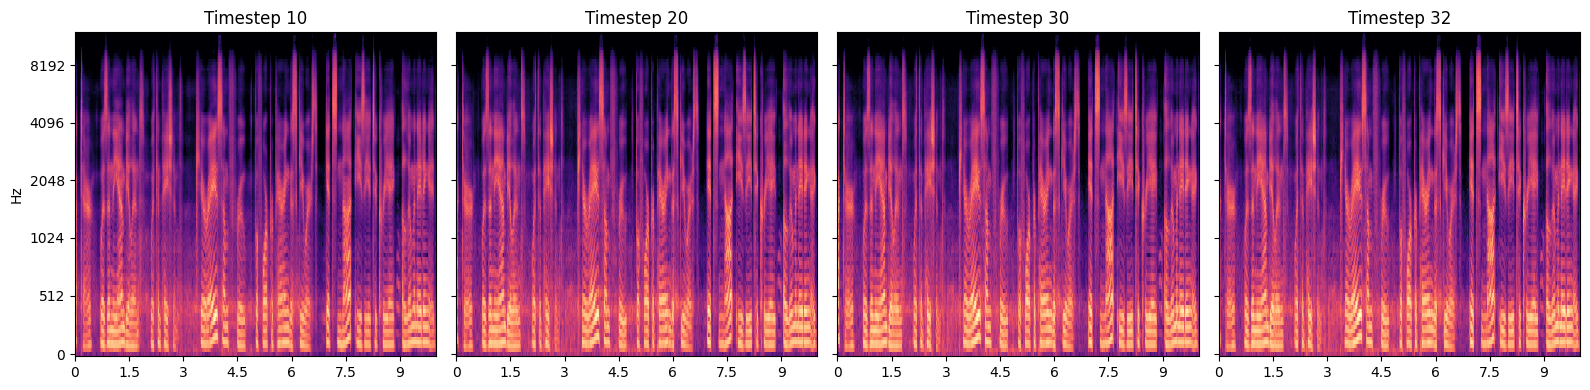

In [34]:
from random import random
from typing import Callable

import torch
import torchaudio
import torch.nn.functional as F
from torch import nn
from torch.nn.utils.rnn import pad_sequence
from torchdiffeq import odeint

from f5_tts.model.modules import MelSpec
from f5_tts.model.utils import (
    default,
    exists,
    get_epss_timesteps,
    lens_to_mask,
    list_str_to_idx,
    list_str_to_tensor,
    mask_from_frac_lengths,
)

import librosa
import tqdm
from matplotlib import pyplot as plt
from IPython.display import Audio, display

%matplotlib inline

sample_rate = 24000

target_sample_rate = 24000
n_mel_channels = 100
hop_length = 256
win_length = 1024
n_fft = 1024
target_rms = 0.1

def estimate_noise_spectrum(mel_spectrogram, percentile=10):
    """通过计算功率谱的较低分位数来粗略估计噪声谱"""
    # 假设输入是 (B, T, F)
    power_spec = torch.abs(mel_spectrogram) ** 2
    # 沿着时间轴计算分位数
    noise_spec = torch.quantile(power_spec, q=percentile/100.0, dim=1, keepdim=True)
    # 广播回原始形状
    return noise_spec.repeat(1, mel_spectrogram.shape[1], 1)

@torch.no_grad()
@torch.autocast(device_type="cuda", dtype=torch.float16)
def sample_denoise_pnp_flow(
    self,
    noisy_audio_path,
    vocoder,
    *,
    text=[" "],  # Null condition for unconditional generation
    pnp_steps=100, # 对应论文中的 N，即迭代总步数
    cfg_strength=1.0,
    # --- PnP-Flow 核心超参数 ---
    # 控制数据保真梯度的学习率，gamma_n = gamma_scale * (1 - t_n)^gamma_a
    gamma_a=0.8,         # 论文中建议的指数 a
    gamma_scale=1.0,     # 学习率的缩放因子，需要微调
    # ---
    intermediate_steps_stride=10,
):
    self.eval()

    # --- 数据准备 (与你原来的代码完全相同) ---
    audio, sr = torchaudio.load(noisy_audio_path)
    if audio.shape[0] > 1: audio = torch.mean(audio, dim=0, keepdim=True)
    if sr != 24000: audio = torchaudio.transforms.Resample(sr, 24000)(audio)
    
    # y_noisy 是我们的测量值 y
    y_noisy = self.mel_spec(audio.to(self.device)).permute(0, 2, 1)
    y_noisy = y_noisy.to(next(self.parameters()).dtype)
    print("Noisy Mel shape:", y_noisy.shape)

    y_power_spec = torch.abs(y_noisy) ** 2
    noise_power_spec_est = estimate_noise_spectrum(y_noisy, percentile=10) # 10% 是一个可调参数
    # 避免除以零
    noise_power_spec_est = torch.clamp(noise_power_spec_est, min=1e-8)
    # 计算维纳滤波风格的权重
    snr_est = y_power_spec / noise_power_spec_est
    W = snr_est / (snr_est + 1.0) # Wiener-like weight
    W = torch.clamp(W, min=0.0, max=1.0) # 确保权重在[0,1]
    
    batch, max_duration, device = *y_noisy.shape[:2], y_noisy.device
    
    # --- 条件准备 (与你原来的代码完全相同) ---
    cond = torch.zeros(batch, 0, y_noisy.shape[-1], device=device, dtype=y_noisy.dtype)
    lens = torch.full((batch,), 0, device=device, dtype=torch.long)

    if isinstance(text, list):
        if exists(self.vocab_char_map):
            text = list_str_to_idx(text, self.vocab_char_map).to(device)
        else:
            text = list_str_to_tensor(text).to(device)
        assert text.shape[0] == batch
    
    cond_mask = lens_to_mask(lens)
    cond = F.pad(cond, (0, 0, 0, max_duration - 0), value=0.0)
    cond_mask = F.pad(cond_mask, (0, max_duration - cond_mask.shape[-1]), value=False).unsqueeze(-1)
    step_cond = torch.where(cond_mask, cond, torch.zeros_like(cond))
    
    # ==============================================================================
    # --- PnP-Flow 主循环 ---
    # ==============================================================================

    # 初始化 x_n。PnP-Flow 的优势之一是初始化不敏感。
    # 我们可以从一个纯噪声开始，对应 t=0。
    x_n = torch.randn_like(y_noisy)

    # 创建时间序列 t_n = n / N
    pnp_times = torch.linspace(0.0, 1.0, pnp_steps + 1, device=device)
    
    intermediate_audios = {}
    
    pbar = tqdm.trange(pnp_steps)
    for n in pbar:
        t_n = pnp_times[n]

        # --- 步骤 1: 数据保真梯度步 ---
        # 损失函数 F(x) = 0.5 * ||x - y_noisy||^2
        # 梯度 ∇F(x_n) = x_n - y_noisy
        # grad_f = x_n - y_noisy
        grad_f = W * (x_n - y_noisy)
        
        # 计算时间依赖的学习率 gamma_n
        gamma_n = gamma_scale * ((1 - t_n) ** gamma_a)
        
        # 执行梯度步
        z_n = x_n - gamma_n * grad_f

        # --- 步骤 2: 线性插值步 ---
        # 采样一个全新的噪声 ε
        epsilon_noise = torch.randn_like(z_n)
        
        # 执行插值
        z_tilde_n = (1 - t_n) * epsilon_noise + t_n * z_n
        
        # --- 步骤 3: PnP 去噪步 ---
        # 定义去噪器 D_t(x) = x + (1-t) * v^θ(x, t)
        # 我们需要先获取速度场 v^θ(z̃_n, t_n)
        
        # 准备模型输入的时间张量
        time_tensor = torch.full((batch,), t_n, device=device, dtype=x_n.dtype)
        
        # 调用模型，获取速度场 v_theta (包含CFG逻辑)
        pred_cfg = self.transformer(
            x=z_tilde_n,
            cond=step_cond,
            text=text,
            time=time_tensor,
            cfg_infer=True,
            cache=False, # 在循环中不要使用缓存
        )
        pred, null_pred = torch.chunk(pred_cfg, 2, dim=0)
        v_theta = pred + (pred - null_pred) * cfg_strength
        
        # 应用PnP去噪器公式
        x_n_plus_1 = z_tilde_n + (1 - t_n) * v_theta
        
        # 更新 x_n 为下一次迭代做准备
        x_n = x_n_plus_1.detach() # 使用 detach 以免梯度累积

        # --- 记录中间结果 (与你原来的代码逻辑相同) ---
        current_step_for_logging = n + 1
        if current_step_for_logging % intermediate_steps_stride == 0 or current_step_for_logging == pnp_steps:
            # 使用 vocoder 解码当前结果 x_n
            mel_for_vocoder = x_n.permute(0, 2, 1)
            wave = vocoder.decode(mel_for_vocoder.to(torch.float32))
            wave_numpy = wave.squeeze().cpu().numpy()
            intermediate_audios[current_step_for_logging] = wave_numpy
            pbar.set_description(f"PnP Step {current_step_for_logging}/{pnp_steps}")

    return intermediate_audios


def inference_denoise_with_pnp_flow(
    noisy_audio_path,
    model_obj,
    vocoder,
    device,
    pnp_steps=100, # PnP-Flow 迭代步数
    cfg_strength=2.0,
    gamma_a=0.8,
    gamma_scale=1.0,
    stride=10
):
    
    # 绑定新的 PnP-Flow 采样函数
    import types
    model_obj.sample_denoise_pnp_flow = types.MethodType(sample_denoise_pnp_flow, model_obj)
    
    intermediate_audios = model_obj.sample_denoise_pnp_flow(
        noisy_audio_path=noisy_audio_path,
        vocoder=vocoder,
        text=[" "], # 无条件
        pnp_steps=pnp_steps,
        cfg_strength=cfg_strength,
        gamma_a=gamma_a,
        gamma_scale=gamma_scale,
        intermediate_steps_stride=stride,
    )
            
    return intermediate_audios

# --- 5. 运行并展示结果 ---

# noisy_audio_path="/mnt/workspace/zhangjunan/F5-TTS/src/f5_tts/infer/tests/voicebank_demand_16k_noisy/p232_014.wav"
# noisy_audio_path="/mnt/workspace/zhangjunan/F5-TTS/src/f5_tts/infer/tests/voicebank_demand_16k_noisy/p232_018.wav"
# noisy_audio_path="/mnt/workspace/zhangjunan/F5-TTS/src/f5_tts/infer/tests/p232_005.wav"
# noisy_audio_path="/mnt/workspace/zhangjunan/F5-TTS/src/f5_tts/infer/tests/p232_003.wav"
# noisy_audio_path="/mnt/workspace/zhangjunan/F5-TTS/src/f5_tts/infer/tests/suvi_happy.wav"
noisy_src = "/mnt/workspace/zhangjunan/F5-TTS/src/f5_tts/infer/tests/voicebank_demand_16k_noisy/"
noisy_src = "/mnt/workspace/zhangjunan/F5-TTS/src/f5_tts/infer/tests/dns2020_no_reverb_noisy/"

enh_dst = "./tests/pnp-flow"
noisy_audio_paths = [
    os.path.join(noisy_src, i)
    for i in os.listdir(noisy_src) if i.endswith(".wav")
]

import shutil
import random
noisy_audio_path = random.choice(noisy_audio_paths)
print(f"选择的测试音频文件: {noisy_audio_path}")
# noisy_audio_path = "/mnt/workspace/zhangjunan/F5-TTS/src/f5_tts/infer/tests/dns2020_no_reverb_noisy/clean_fileid_2.wav"
shutil.copy(noisy_audio_path, f"{enh_dst}/{Path(noisy_audio_path).name}_noisy.wav")
intermediate_results = inference_denoise_with_pnp_flow(
    noisy_audio_path=noisy_audio_path,
    model_obj=ema_model,
    vocoder=vocoder,
    device=device,
    pnp_steps=32, # 总迭代次数
    cfg_strength=2.0,
    gamma_a=2,
    gamma_scale=2, # 这是一个需要调整的关键参数！
    stride=10
)

# 循环展示每个中间步骤的音频
# for step, audio_data in sorted(intermediate_results.items()):
#     print(f"--- 音频 @ Timestep {step} ---")
#     audio_player = Audio(data=audio_data, rate=target_sample_rate)
#     display(audio_player)
audio_data = intermediate_results[list(intermediate_results.keys())[-1]]
audio_data = audio_data / np.max(np.abs(audio_data))
# audio_player = Audio(data=intermediate_results[list(intermediate_results.keys())[-1]], rate=24000)
audio_player = Audio(data=audio_data, rate=24000)
display(audio_player)

# torchaudio.save("denoise_out_naive.wav", torch.from_numpy(intermediate_results[list(intermediate_results.keys())[-1]]).unsqueeze(0), 24000)
torchaudio.save(f"{enh_dst}/{Path(noisy_audio_path).name}_output.wav", torch.from_numpy(audio_data).unsqueeze(0), 24000)

import matplotlib.pyplot as plt
import librosa
import librosa.display
import numpy as np

sorted_items = sorted(intermediate_results.items())
num_plots = len(sorted_items)

fig, axes = plt.subplots(1, num_plots, figsize=(num_plots * 4, 4), sharey=True)
if num_plots == 1:
    axes = [axes]

for i, (step, audio_data) in enumerate(sorted_items):
    mel = librosa.feature.melspectrogram(    
        y=audio_data, 
        sr=24000, 
        n_fft=n_fft, 
        hop_length=hop_length, 
        win_length=win_length, 
        n_mels=n_mel_channels
    )

    mel_db = librosa.power_to_db(mel, ref=np.max)
    
    img = librosa.display.specshow(
        mel_db,
        sr=target_sample_rate,
        hop_length=hop_length,
        x_axis='time',
        y_axis='mel',
        ax=axes[i]
    )
    axes[i].set_title(f'Timestep {step}')
    if i > 0:
        axes[i].set_ylabel(None)
    axes[i].set_xlabel(None)

plt.tight_layout()
plt.show()